In [68]:
import geopandas as gpd
import time
import os
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
from osgeo import gdal
from matplotlib import pyplot
import rasterio
import rasterio.mask
from xml.dom.minidom import parse
import numpy
import pandas as pd
from requests.auth import HTTPBasicAuth
from dotenv import load_dotenv
import os
import requests
PLANET_API_KEY = "17de9ecc82734c1caf0ef0da1bf90d97"
import datetime


In [15]:
# Set filepath
fp = "shapes/trial-design-n-2021.shp"
# Read file using gpd.read_file()
trial_design = gpd.read_file(fp)
#str(data.iloc[0]['geometry'])
# check the data
#gpd.GeoSeries([data.iloc[0]['geometry']])
print(len(trial_design.index))
trial_design.head(2)

140


,geometry
0,"POLYGON ((-89.06084 39.72437, -89.06084 39.724..."
1,"POLYGON ((-89.06172 39.72437, -89.06172 39.724..."


In [16]:
df = pd.read_csv('data/res.csv')
print(len(df.index))
df.head(3)
ids = [v.id for k,v in df.iterrows()]

34


In [17]:
for geom in trial_design.iterrows():
    print(geom[1])
    break

geometry    POLYGON ((-89.06083529248441 39.72436997827738...
Name: 0, dtype: object


In [30]:
def calc_ndvi(image_path, xml_path, out_path):
    my_image = rasterio.open(image_path)
    band_red = my_image.read(3)
    band_nir = my_image.read(4)
    xmldoc = parse(xml_path)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)

    # Multiply by corresponding coefficients
    band_red = band_red * coeffs[3]
    band_nir = band_nir * coeffs[4]
    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)
    with rasterio.open(out_path, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))
#    plt.imsave(f"data/imgs/{id_}_subarea_ndvi_cmap.png", ndvi, cmap=plt.cm.summer)
    return my_image

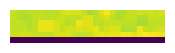

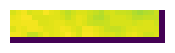

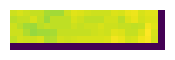

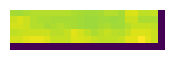

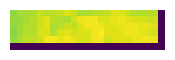

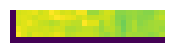

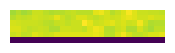

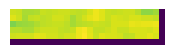

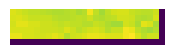

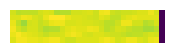

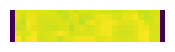

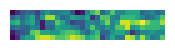

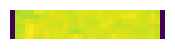

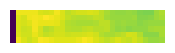

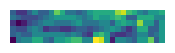

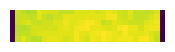

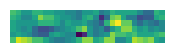

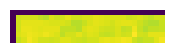

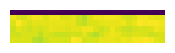

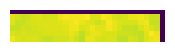

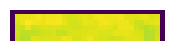

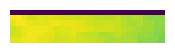

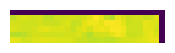

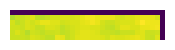

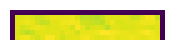

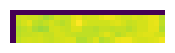

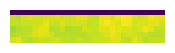

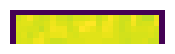

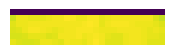

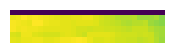

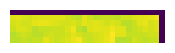

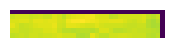

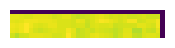

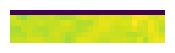

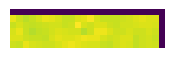

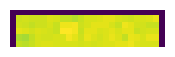

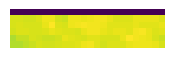

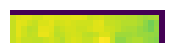

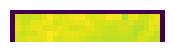

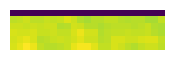

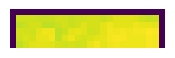

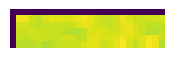

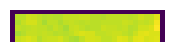

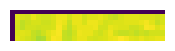

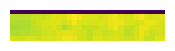

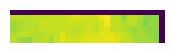

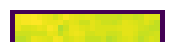

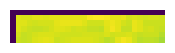

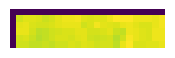

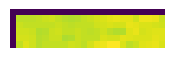

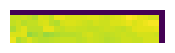

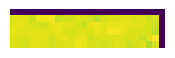

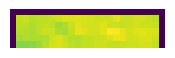

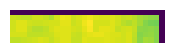

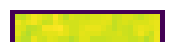

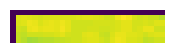

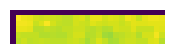

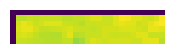

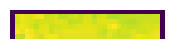

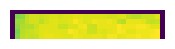

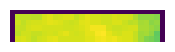

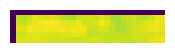

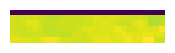

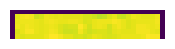

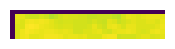

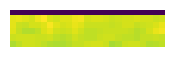

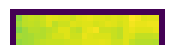

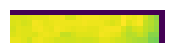

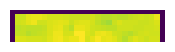

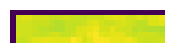

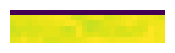

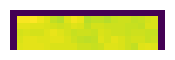

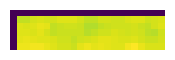

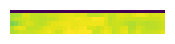

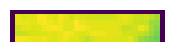

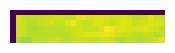

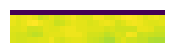

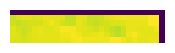

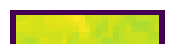

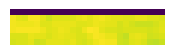

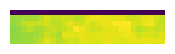

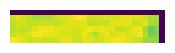

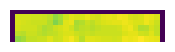

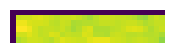

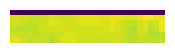

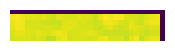

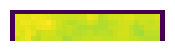

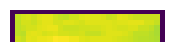

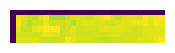

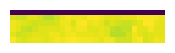

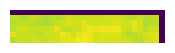

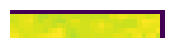

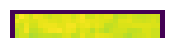

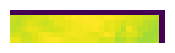

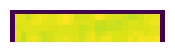

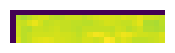

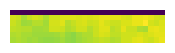

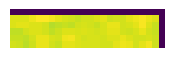

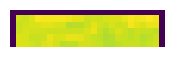

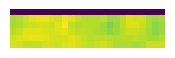

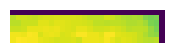

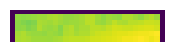

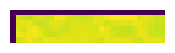

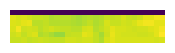

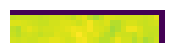

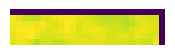

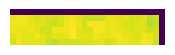

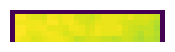

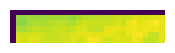

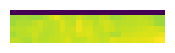

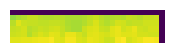

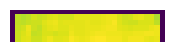

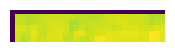

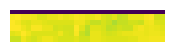

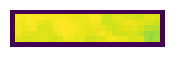

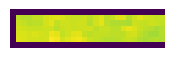

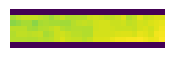

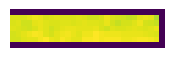

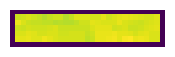

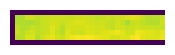

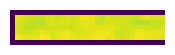

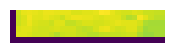

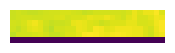

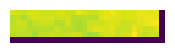

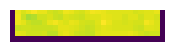

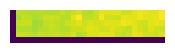

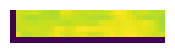

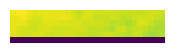

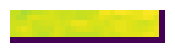

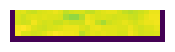

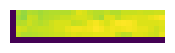

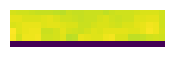

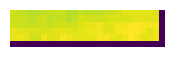

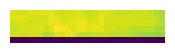

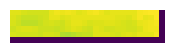

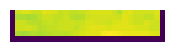

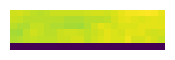

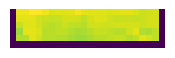

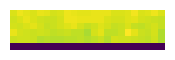

In [82]:
res = []
col = 1
for id_ in ids[2:]:
    image_path = f"data/imgs/{id_}_subarea.tif"
    out_path = f"data/ndvi/{id_}.tif"
    xml_path = f"data/imgs/{id_}_subarea.xml"
    for p in ['data/imgs', 'data/ndvi', 'data/imgs']:
        if not os.path.exists(p):
            os.makedirs(p)
    trial_image = calc_ndvi(image_path,xml_path,out_path)
    i = 0
    for geom in trial_design.iterrows():
        plot_ndvi_image, plot_transform = rasterio.mask.mask(trial_image, geom[1], crop=True)
        out_plot = trial_image.meta
        out_plot.update(
            {
                "height": plot_ndvi_image.shape[1],
                "width": plot_ndvi_image.shape[2],
                "transform": plot_transform,
            }
        )
        row = {}
        row['image_id'] = image_path
        row['plot_id'] = str(i)
        row['xml_path'] = xml_path
        row['ndvi_path'] = out_path
        row['max_ndvi'] = plot_ndvi_image.max()
        row['mean_ndvi'] = plot_ndvi_image.mean()
        row['median_ndvi'] = np.median(plot_ndvi_image)
        row['min_ndvi'] = plot_ndvi_image.min()
        res.append(row)
        if i != 139:
            #fig.add_subplot(i + 1, col, i + 1)
            fig = plt.figure(figsize=(2, 1))
            ax = fig.gca()
            ax.set_axis_off()
            #ax.autoscale(False)
            #fig.add_subplot(139, 2, i+1)

            #plt.axis('off')
            plt.imshow(plot_ndvi_image[1])
            plt.show()

        i += 1
    col += 1
    break


In [34]:
#saves results as a csv
import pandas as pd
df = pd.DataFrame(res)
df.to_csv('data/plot_results.csv', index=None)

'data/cropped/20210822_164358_51_2407/0.tiff'

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  20,  16,   0],
       [142, 100,  75, ...,  16,  14,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)